In [181]:
# Importation des bases
import pandas as pd
import functions as fc
import numpy as np

dict_data = fc.read_all_raw(fc.list_bases)
dict_data.keys()

dict_keys(['rejets', 'etablissements', 'emissions', 'Trait_dechets_non_dangereux', 'Trait_dechets_dangereux', 'Prod_dechets_non_dangereux', 'Prod_dechets_dangereux', 'Prelevements'])

In [188]:
df = fc.clean_data_etab(
    dict_data['etablissements']
    )

In [208]:
dict_data['etablissements'].head(1)

,identifiant,nom_etablissement,numero_siret,adresse,code_postal,commune,departement,region,coordonnees_x,coordonnees_y,code_epsg,code_ape,libelle_ape,code_eprtr,libelle_eprtr
0,9073402,STEP - BEZIERS,41003460701688,Plaine Saint Pierre,34500,BEZIERS,HERAULT,OCCITANIE,672948.91,1813634.13,27572.0,3700Z,Collecte et traitement des eaux usées,5.(f),Installations de traitement des eaux urbaines ...


In [296]:
request_template = '''{{ 
  "query": {{
    "bool": {{
      "should": [
        {{"multi_match" : {{"query":"{nom_etablissement}", "type":"best_fields", "fields": [ "denom", "enseigne", "nom_comm_et", "adr_et_l1","adr_et_l2", "denom_condense", "enseigne_et1" ],"tie_breaker": 0.1}}}},
        {{ "match": {{ "sir_adr_et_com_lib":  {{ "query":  "{commune}"  }} }} }}
      ],
      "filter": [
        {{ "prefix":  {{ "apet": "{code_apet}" }}}},
        {{ "geo_distance": {{
                  "distance": "10km",
                  "location": {{
                        "lat": "{y}", 
                        "lon": "{x}"
                              }}
                            }}
            }}
      ]
    }}
  }},
  "size": 1
}}'''

In [305]:
fc = reload(fc)
out = fc.pipeline_request(df.dropna(subset = ["code_epsg"]), request_template, cols = ['nom_etablissement',  'commune', 'code_apet', 'y', 'x'])

/home/coder/local/bin/conda/envs/basesspcloud/lib/python3.10/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


We found correct SIRET in 57.71% of cases


/home/coder/work/irep/notebooks/functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["siret_elastic"] = [res['responses'][i]['hits']['hits'][0]["_source"]["siret_id"] if \
/home/coder/work/irep/notebooks/functions.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["match"] = (df_temp["numero_siret_true"].astype(str) == df_temp["siret_elastic"].astype(str))
/home/coder/work/irep/notebooks/functions.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [306]:
out.loc[df['match'], ['nom_etablissement',"code_ape", "code_apet", "nom_etab_elastic"]]

,nom_etablissement,code_ape,code_apet,nom_etab_elastic
34,SCEA DAVID RIOU,0146Z,0146,SCEA DAVID RIOU
39,SO.BA.CA Carrière,0812Z,0812,SOCIETE BASQUE DE CARRIERES
40,SMDVDMAT TRIFYL,3821Z,3821,SYNDICAT MIXTE DEPARTEMENTAL POUR LA VALORISAT...
43,GROS ENVIRONNEMENT,4941A,4941,PAPREC GRAND EST
54,CASTAGNIER PERRET,3811Z,3811,ETABLISSEMENTS CASTAGNIER PERRET
...,...,...,...,...
8908,SCEA LEMOINE,0147Z,0147,LEMOINE
8909,EARL ROY Michel,0147Z,0147,EARL ROY
8944,DURAND Luc,4312A,4312,LUC DURAND
8954,LABORATOIRES RIVADIS SAS,2042Z,2042,LABORATOIRES RIVADIS SAS


In [307]:
out.loc[~out['match'], ['nom_etablissement',"code_ape", "code_apet", "nom_etab_elastic"]]

,nom_etablissement,code_ape,code_apet,nom_etab_elastic
11,STEP - GRENOBLE / AQUAPOLE,3700Z,3700,COMMUNE DE FONTANIL CORNILLON
12,STEP Villefontaine/Traffeyere,3700Z,3700,SEDE ENVIRONNEMENT
13,STEP - Petite Californie,3700Z,3700,AFD44
16,STEP - MULHOUSE,3700Z,3700,COMMUNE DE MULHOUSE
40,SMDVDMAT TRIFYL,3821Z,3821,SYNDICAT MIXTE DEPARTEMENTAL POUR LA VALORISAT...
...,...,...,...,...
8937,CHB SAS - ISDI du Locum,0812Z,0812,SAGRADRANSE
8938,SABCOR,1011Z,1011,SOCIETE D'ABATTAGE DE BRIVE
8940,Les fromageries Saint-Saviol,1051C,1051,FROMAGERIES SAINT SAVIOL
8942,Luc DURAND,4312A,4312,LUC DURAND


In [308]:
request_template_2 = '''{{ 
  "query": {{
    "bool": {{
      "should": [
        {{"multi_match" : {{"query":"{nom_etablissement}", "boost": 30, "type":"best_fields", "fields": [ "denom", "enseigne", "nom_comm_et", "adr_et_l1","adr_et_l2", "denom_condense", "enseigne_et1" ],"tie_breaker": 0.1}}}},
        {{ "match": {{ "sir_adr_et_com_lib":  {{ "query":  "{commune}"  }} }} }}
      ],
      "filter": [
        {{ "match":  {{ "adr_et_post": "{code_postal}" }} }}
      ]
    }}
  }},
  "size": 1
}}'''

In [310]:
df_no_match = out.loc[~df['match']].loc[:, df.columns]

In [311]:
out_2 = fc.pipeline_request(df_no_match, request_template_2, cols = ['nom_etablissement',  'commune', 'code_postal'])

We found correct SIRET in 11.89% of cases


/home/coder/local/bin/conda/envs/basesspcloud/lib/python3.10/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [313]:
out_2.loc[out_2['match'], ['nom_etablissement',"code_ape", "code_apet", "nom_etab_elastic", "numero_siret_true", "siret_elastic"]]

,nom_etablissement,code_ape,code_apet,nom_etab_elastic,numero_siret_true,siret_elastic
63,MICRONOR,2561Z,2561,MICRONOR,68200029400038,68200029400038
74,JEAN PIERRE TALLEC L'HERITAGE DU GOUT,1013A,1013,JEAN-PIERRE TALLEC-L'HERITAGE DU GOUT,57202153300045,57202153300045
80,EARL DARE,0150Z,0150,EARL DARE,38822958500012,38822958500012
91,SCEA DES BRUYERES,0146Z,0146,DES BRUYERES,38276225000019,38276225000019
109,DEMOLITION AUTOMOBILE CROIX LUIZET,4511Z,4511,DEMOLITION AUTOS DE CROIX LUIZET,33458241800029,33458241800029
...,...,...,...,...,...,...
8674,Mairie,3811Z,3811,COMMUNE DE XERTIGNY,21880530700012,21880530700012
8678,LETOURNEUR MICHEL,4511Z,4511,,90697142900020,90697142900020
8720,ALUMINIUM FERRI,2599B,2599,ALUMINIUM FERRI,58213749300026,58213749300026
8738,SARL BREMOND Freres ISDI,3821Z,3821,SARL BREMOND,32950383300017,32950383300017


In [317]:
perf_step2 = (out_2['match'].sum() + out['match'].sum())/df.dropna(subset = "code_epsg").shape[0]
print(f"Performance après step2: {perf_step2:.2%}")

Performance après step2: 63.62%


Enjeu : trouver un critère statistique pour valider/invalider des paires elastic

<AxesSubplot:ylabel='Frequency'>

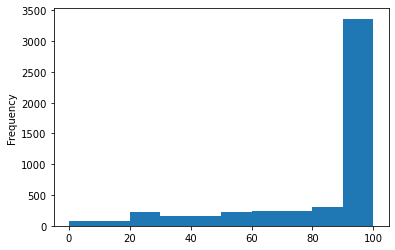

In [321]:
out.loc[out['match'], "textual_distance"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

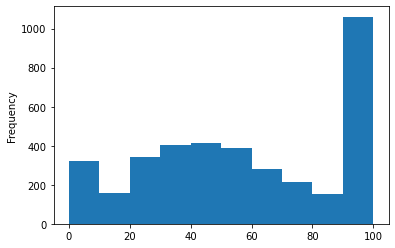

In [322]:
out.loc[~out['match'], "textual_distance"].plot.hist()

In [ ]:
    import folium
    import seaborn as sns

    palette = sns.color_palette("coolwarm", 8)

    temp = out.sample(500)
    temp['color'] = np.where(temp['match'], "blue", "red")

    center = temp[['y', 'x']].mean().values.tolist()
    sw = temp[['y', 'x']].min().values.tolist()
    ne = temp[['y', 'x']].max().values.tolist()

    m = folium.Map(location = center, tiles='Stamen Toner')

    # I can add marker one by one on the map
    for i in range(0,len(temp)):
        folium.Marker([temp.loc[temp['match']].iloc[i]['y'], temp.loc[temp['match']].iloc[i]['x']],
                    popup = temp['nom_etablissement'].iloc[i],
                    icon=folium.Icon(icon="home", color = temp['color'].iloc[i])).add_to(m)

    m.fit_bounds([sw, ne])


In [342]:
m

## Les émissions de CO2

On va commencer par se focaliser sur les gros émetteurs de CO2

In [ ]:
emissions = dict_data['emissions']
emissions_co2 = emissions.loc[emissions['polluant'].str.contains("CO2")]
emissions_co2 = emissions_co2.loc[emissions_co2['polluant'].str.contains('total')]
emissions_co2.head(1)

In [ ]:
emissions_co2['quantite'].div(1000).plot.hist(logx = True)

In [ ]:
dict_data.head(1)

In [ ]:
dict_data['emissions']["annee_emission"].value_counts()

In [ ]:
dict_data['emissions']["milieu"].value_counts()

In [ ]:
dechets_dang = dict_data['Trait_dechets_dangereux']

In [ ]:
dict_data['etablissements']['identifiant'].nunique()

In [ ]:
dict_data['etablissements'].head(1)

In [ ]:
dict_data